# Assignment #2
### Gene Expression and Chromatin Accessibility

#### In this assignment, we will investigate gene expression and chromatin accessibility in healthy and cancerous blood cells.

The data we will look at is from a study of regulatory programs in mixed-phenotype acute leukemia (MPAL). The dataset used several -omic technologies, but we will specifically be investigating single cell RNA and single cell ATAC sequencing of healthy and MPAL cells in peripheral blood and bone marrow cells.

In this assignment, we're going to be looking for trends in gene expression and chromatin accessibility. More specifically, we'll investigate how chromatin accessibility of putative regulatory regions near genes are associated with expression of those genes.

Read the paper to learn more about the study [here](https://www.nature.com/articles/s41587-019-0332-7#Sec2). The data is located [here](https://github.com/GreenleafLab/MPAL-Single-Cell-2019?tab=readme-ov-file) (data is already included in the zip file, so don't worry about downloading it from there).

### First, let's load in our packages

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [32]:
# You may need to edit this line if you can't load the dataset
os.chdir('C:/Users/user/OneDrive/Desktop/Bio/Assignment2/') # TODO: comment this out before uploading

#### And then, our data

In [33]:
scRNA_genes = pd.read_csv('./Data/scRNA-Healthy-genes-meta.csv', index_col=0)
scRNA_genes.index = scRNA_genes['gene_name']
scRNA_genes.head()

,seqnames,start,end,width,strand,gene_name,gene_id,exonLength
gene_name,,,,,,,,
FAM138A,chr1,34554,36081,1528,-,FAM138A,ENSG00000237613,1219
OR4F5,chr1,69091,70008,918,+,OR4F5,ENSG00000186092,918
AL627309.1,chr1,134901,139379,4479,-,AL627309.1,ENSG00000237683,2661
OR4F29,chr1,367640,368634,995,+,OR4F29,ENSG00000235249,995
OR4F16,chr1,621059,622053,995,-,OR4F16,ENSG00000185097,995


In [34]:
scRNA_cells = pd.read_csv('./Data/scRNA-Healthy-cells-meta.csv', index_col=0)
scRNA_cells.head()

,Group,nUMI_pre,nUMI,nGene,initialClusters,UMAP1,UMAP2,Clusters,BioClassification,Barcode
CD34_32_R5:AAACCTGAGTCGTTTG-1,CD34_D2T1,9277,3917,1787,Cluster2,-8.800932,-1.228907,Cluster8,08_GMP.Neut,AAACCTGAGTCGTTTG-1
CD34_32_R5:AAACCTGGTTCCACAA-1,CD34_D2T1,13073,6023,2552,Cluster3,-9.723482,7.335178,Cluster1,01_HSC,AAACCTGGTTCCACAA-1
CD34_32_R5:AAACGGGCAAGTAATG-1,CD34_D2T1,3091,2094,1199,Cluster5,-4.265697,9.762142,Cluster15,15_CLP.2,AAACGGGCAAGTAATG-1
CD34_32_R5:AAACGGGCAAGTTCTG-1,CD34_D2T1,1949,1454,909,Cluster6,-11.043401,3.148249,Cluster2,02_Early.Eryth,AAACGGGCAAGTTCTG-1
CD34_32_R5:AAAGATGCAGGACGTA-1,CD34_D2T1,12726,5640,2500,Cluster1,-8.012542,4.755098,Cluster5,05_CMP.LMPP,AAAGATGCAGGACGTA-1


In [35]:
scRNA_counts = pd.read_csv('./Data/scRNA-Healthy-counts.csv', index_col=0).T
scRNA_counts.head()

,FAM138A,OR4F5,AL627309.1,OR4F29,OR4F16,FAM87B,LINC00115,FAM41C,AL645608.2,SAMD11,...,LSS,AP001468.1,MCM3AP-AS1,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
CD34_32_R5:AAACCTGAGTCGTTTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
CD34_32_R5:AAACCTGGTTCCACAA-1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
CD34_32_R5:AAACGGGCAAGTAATG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CD34_32_R5:AAACGGGCAAGTTCTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CD34_32_R5:AAAGATGCAGGACGTA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [36]:
scATAC_peaks = pd.read_csv('./Data/scATAC-healthy-peaks-meta.csv', index_col=0)
scATAC_peaks['peak_name'] = scATAC_peaks['seqnames']+'_'+scATAC_peaks['start'].astype('str')+'_'+scATAC_peaks['end'].astype('str')
scATAC_peaks = scATAC_peaks.set_index('peak_name')
scATAC_peaks.head()

,seqnames,start,end,width,strand,score,scoreQuantile,name,GC
peak_name,,,,,,,,,
chr1_762677_763177,chr1,762677,763177,501,*,1775.52063,0.961247,scATAC_16,0.688623
chr1_772952_773452,chr1,772952,773452,501,*,230.24321,0.599258,scATAC_18,0.516966
chr1_773634_774134,chr1,773634,774134,501,*,1448.94360,0.854988,scATAC_19,0.457086
chr1_791914_792414,chr1,791914,792414,501,*,214.05739,0.718766,scATAC_23,0.550898
chr1_805049_805549,chr1,805049,805549,501,*,5867.58594,0.978049,scATAC_30,0.738523


In [37]:
scATAC_cells = pd.read_csv('./Data/scATAC-healthy-cells-meta.csv', index_col=0)
scATAC_cells.head()

,Barcode,FRIP.y,TotalReads.y,Group.y,ProjectUMAP1,ProjectUMAP2,BioClassification,n
BMM_R1_21,CCTAAAGTCCGCCTAT-1,0.534627,17154,BMMC_D5T1,9.737446,-2.393460,22_CD4.M,1
BMM_R1_25,TAAACCGCACATTCTT-1,0.582858,38898,BMMC_D5T1,11.522385,1.818643,24_CD8.CM,2
BMM_R1_38,GCGAGAAGTCTGGTCG-1,0.585004,52162,BMMC_D5T1,10.471289,0.268666,24_CD8.CM,3
BMM_R1_7,CGTGGCACATGGTAAA-1,0.541396,23384,BMMC_D5T1,8.951770,0.505386,23_CD8.EM,4
BMM_R1_9,GAGGATGAGAACGTTA-1,0.542537,46336,BMMC_D5T1,8.050591,-3.854836,21_CD4.N2,5


In [38]:
scATAC_counts = pd.read_csv('./Data/scATAC-healthy-counts.csv', index_col=0).T
scATAC_counts.columns = scATAC_peaks.index
scATAC_counts.head()

peak_name,chr1_762677_763177,chr1_772952_773452,chr1_773634_774134,chr1_791914_792414,chr1_805049_805549,chr1_834039_834539,chr1_856330_856830,chr1_867079_867579,chr1_893848_894348,chr1_901299_901799,...,chrX_153712829_153713329,chrX_153770594_153771094,chrX_153832177_153832677,chrX_153882623_153883123,chrX_153888183_153888683,chrX_154012368_154012868,chrX_154029742_154030242,chrX_154030288_154030788,chrX_154031719_154032219,chrX_154664524_154665024
BMM_R1_21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BMM_R1_25,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BMM_R1_38,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
BMM_R1_7,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BMM_R1_9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# This contains information about which scATAC peaks are associated with which genes. This was calculated by the authors of the paper
peak2genes = pd.read_table('./Data/Peak2Gene-Links-filt.tsv',sep='\t')
peak2genes.head()

,linkName,peakName,geneName,peak_chr,peak_start,peak_end,gene_chr,gene_start,gene_strand,gene_name,...,CorrelationCancer,CorrelationHealthy,PvalCancer,PvalHealthy,FDRCancer,FDRHealthy,nearestGene,nearestGeneDistance,sigCancer,sigHealthy
2,p2gLink_2,chr1_856330_856830,FAM41C,chr1,856330.0,856830.0,chr1,812283.0,-,FAM41C,...,0.421402,0.120335,0.000045,0.351783,0.004405,1.0,RP11-54O7.3,0.0,True,False
3,p2gLink_3,chr1_974838_975338,FAM41C,chr1,974838.0,975338.0,chr1,812283.0,-,FAM41C,...,0.361504,0.141965,0.000471,0.269996,0.025227,1.0,AGRN,19334.0,True,False
4,p2gLink_4,chr1_999461_999961,FAM41C,chr1,999461.0,999961.0,chr1,812283.0,-,FAM41C,...,0.373703,0.133499,0.000300,0.300307,0.018070,1.0,RP11-54O7.18,792.0,True,False
5,p2gLink_5,chr1_1002022_1002522,FAM41C,chr1,1002022.0,1002522.0,chr1,812283.0,-,FAM41C,...,0.371855,-0.060107,0.000321,0.614855,0.019021,1.0,RP11-54O7.18,3353.0,True,False
6,p2gLink_6,chr1_791914_792414,NOC2L,chr1,791914.0,792414.0,chr1,894689.0,-,NOC2L,...,0.389822,-0.040189,0.000162,0.730223,0.011467,1.0,FAM41C,19868.0,True,False


## 1: Preprocessing

First, we're going to take a look at our dataset and get it ready for our analysis.

**A Note on the Dataset**

These data are very big! Originally it included over 50,000 cells and 20,000 genes (for scRNA-seq), and 70,000 cells and 500,000 peaks (for scATAC-seq)! This is too big to run on a personal computer, so we reduced the number of cells to ~10,000 for both datasets and reduced the scATAC-seq peaks to only include peaks that are significantly associated with genes using the `peak2genes` table. As a result, it is now small enough to run on a computer.

#### a) Overview of the Data

1. Read a little about the [study](https://www.nature.com/articles/s41587-019-0332-7#Sec2). What kind of tissue is our data from? What disease are we studying? Briefly describe their approach to studying this disease.

*ANSWER HERE* <br>
The data in the study is from bone marrow and peripheral blood mononuclear cell(BMMCs and PMBCs) and it is studying the disease of mixed-phenotype acute leukemia (MPAL). This study uses single-cell multiomic approach that intergrates protein quantification, transciptome profiling, and chromatin accessibility analysis to indentify regulatory programs in MPAL.

2. Take a look at the datasets. We have one scRNA-seq dataset and one scATAC-seq dataset. For each dataset, what does a row represent? What does a column represent?

*ANSWER HERE*<br>In the dataset scRNA-seq the row represents genes and columns represents a single cell. And the scATAC-seq dataset the row represents a chromatin region (peak)—a genomic location with accessible DNA and column represents a single cell.

3. For each dataset, what does a single entry of the matrix represent? How is this number derived from sequencing data for each modality? In other words, what is a single "count" in our scRNA-seq and in our scATAC-seq dataset? Be specific to how the data is actually generated.

*ANSWER HERE*<br>A single entry in the scRNA-seq matrix (gene x cell) represents the number of unique mRNA transcripts for a specific gene in a specific cell.This value is derived through a process where mRNA molecules are captured in droplets using oligo-dT primers attached to barcoded beads. Each captured transcript is labeled with a cell barcode and a Unique Molecular Identifier. The mRNA is then reverse-transcribed into cDNA, amplified, and sequenced. Sequencing reads are then mapped to a reference genome to identify the gene of origin, and finally, the number of unique UMIs for each gene-cell pair is counted to generate the final expression matrix. <br>A single entry in the scATAC-seq matrix (peak × cell) represents the number of sequencing reads that mapped to a specific accessible chromatin region in a specific cell. In the process of Tn5 transposition, each cell’s chromatin is treated with Tn5 transposase, which inserts sequencing adapters into open regions of DNA. These fragments are then barcoded with a cell barcode to identify their cell of origin, followed by amplification and sequencing. The sequenced reads are aligned to a reference genome in the alignment step. Next, in peak calling, regions with high read density across multiple cells are identified as “peaks,” which are putative regulatory regions. Finally, in the counting step, the number of Tn5 insertions (read fragments) that fall within each peak in each cell is counted, creating a dataset that represents chromatin accessibility at single-cell resolution.

4. Finally, for the scATAC-seq data, we have one additional table called `peak2genes`. This is a table computed by the authors that links accessibility of certain chromatin regions to expression of certain genes. Why are the authors interested in identifying these links? Why are there multiple rows for the same gene? Why are there multiple genes associated with each peak?

*ANSWER HERE*<br>The authors want to find peak-to-gene links to understand how open regions of DNA (peaks) control gene activity. If a region is open and a nearby gene is turned on, it may be a regulatory element like an enhancer or promoter.  

There are multiple rows for the same gene because one gene can be controlled by many different DNA regions.There are also multiple genes for the same peak because one open region might help turn on several nearby genes. Which helps the authors see how gene activity is controlled in healthy and leukemic cells.

#### b) Preprocessing

1. In the paper, the authors mention that cells with fewer than 400 informative genes were filtered out of the scRNA-seq dataset. How would you confirm that the data is already filtered in this way?

In [99]:
# CODE HERE
nonzero_gene_counts = (scRNA_counts > 0).sum(axis=1)
num_low_quality_cells = (nonzero_gene_counts < 400).sum()
print(f"Number of cells with < 400 detected genes: {num_low_quality_cells}")
print(f"Total number of cells: {len(nonzero_gene_counts)}")

Number of cells with < 400 detected genes: 0
Total number of cells: 10000


2. Looks like the both the scATAC and scRNA data are not normalized. Read the following excerpt from the paper about the scRNA-seq dataset, and normalize the scRNA-seq dataset using the method described.

    scRNA-seq: "We first log normalized the transcript counts by first depth normalizing to 10,000 and adding a pseudocount before a log2 transform (log2(counts per ten thousand transcripts + 1))"

   For the scATAC-seq dataset, use the same method (log2(counts per ten thousand + 1)) to normalize the data.

In [100]:
# CODE HERE
scRNA_depth = scRNA_counts.sum(axis=1)# Normalize scRNA-seq
scRNA_normalized = scRNA_counts.div(scRNA_depth, axis=0) * 10000
scRNA_normalized = np.log2(scRNA_normalized + 1) # Log transform (log2(count + 1))

scATAC_depth = scATAC_counts.sum(axis=1) # Normalize scATAC-seq 
scATAC_normalized = scATAC_counts.div(scATAC_depth, axis=0) * 10000
scATAC_normalized = np.log2(scATAC_normalized + 1)

In [101]:
total_sum_scRNA = scRNA_normalized.values.sum()
print(f"Total sum of normalized scRNA-seq matrix: {total_sum_scRNA:.2f}")
total_sum_scATAC = scATAC_normalized.values.sum()
print(f"Total sum of normalized scATAC-seq matrix: {total_sum_scATAC:.2f}")

Total sum of normalized scRNA-seq matrix: 36138590.43
Total sum of normalized scATAC-seq matrix: 30263006.78


**Sanity Check**: The sum of your normalized scRNA count matrix should be `36138590.428`, and the sum of your normalized scATAC count matrix should be `30263006.784`

## 2: Healthy Cells

In this section, we'll investigate the association between putative regulatory elements near genes and expression of those genes in various cell types. Recall the regulatory elements that aid in transcription of genes (figure). There are promoters, enhancers, and repressors. Let's investigate gene expression and uncover how various regulatory elements may associate with altered expression. We'll do this by looking at gene expression using scRNA-seq and chromatin accessibility using scATAC-seq.

<img width=500 src='attachment:073aa4b0-04c5-4db8-ac15-c0392ad981a8.png' alt='https://www.ck12.org/user%3abiologyepisd/book/episd-biology-version-2.0-district-version/section/18.1/'>

#### a) Cell Type Identification with Marker Genes

1. The authors of the dataset have already dimensionality reduced the data and stored their own UMAP embeddings in the scRNA_cells and scATAC_cells dataframes. In addition, they have already clustered the dataset using shared nearest neighbor clustering and already annotated these clusters by using marker genes to identify cell types. Firstly, plot the UMAP embeddings of each of these two datasets below in a UMAP_1 vs UMAP_2 scatterplot. Also, color this plot with the annotated clusters in the `BioClassification` column.

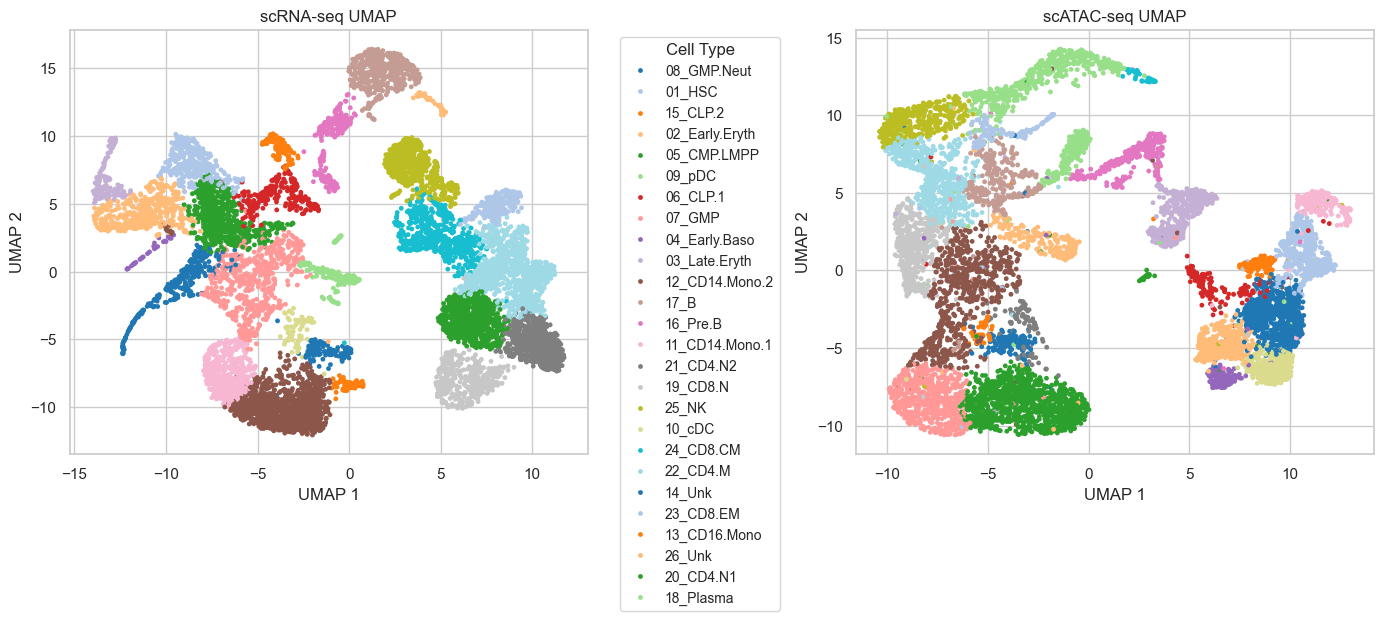

In [104]:
# CODE HERE
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# scRNA-seq UMAP
sns.scatterplot(
    ax=axes[0],
    data=scRNA_cells,
    x='UMAP1', y='UMAP2',
    hue='BioClassification',
    palette='tab20',
    s=12, linewidth=0
)
axes[0].set_title("scRNA-seq UMAP")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
axes[0].legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# scATAC-seq UMAP
sns.scatterplot(
    ax=axes[1],
    data=scATAC_cells,
    x='ProjectUMAP1', y='ProjectUMAP2',
    hue='BioClassification',
    palette='tab20',
    s=12, linewidth=0
)
axes[1].set_title("scATAC-seq UMAP")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")
axes[1].legend([], [], frameon=False)

plt.tight_layout()
plt.show()




2. In studies like this, cell types are often identified through unsupervised clustering followed by differential expression analysis to identify known cell type marker genes significantly associated with one (or a subset of) cluster(s). To see how this works, we'll just look at one example where we perform this analysis to find marker genes that separate T cell clusters from the remaining cells. To start, let's split our dataset into two groups, T-Cell and non-T-Cell. Use the list below to create a new column in the scRNA_cells dataframe that labels cells as either T-Cell or non-T-Cell.

   **Sanity Check** You should have 3620 T-cells and 6380 non-T-cells.

In [51]:
t_cell_clusters = ['21_CD4.N2', '19_CD8.N', '24_CD8.CM', '22_CD4.M', '23_CD8.EM','20_CD4.N1']

In [52]:
# CODE HERE
scRNA_cells['CellTypeGroup'] = scRNA_cells['BioClassification'].apply(
    lambda x: 'T-Cell' if x in t_cell_clusters else 'non-T-Cell'
)
print(scRNA_cells['CellTypeGroup'].value_counts())


CellTypeGroup
non-T-Cell    6380
T-Cell        3620
Name: count, dtype: int64


3. Now, let's do differential expression between these groups. CD3D is a T-Cell marker gene that encodes one chain of the CD3 T-Cell co-receptor protein complex. Perform differential expression using the logistic regression technique from class (and discussion) to identify the p-value and fold change of each gene in the dataset. Show that CD3D is differentially expressed in T-Cells.

   Use the function below to do this. In the end, you should have a p-value, and fold change for CD3D. Describe how this differential expression test works and indicate whether CD3D is upregulated or downregulated in T-Cells.

In [54]:
def diff_exp(gene, A, B):
    N1 = A.shape[0]
    N2 = B.shape[0]
    logr_labels = np.concatenate((np.ones(N1), np.zeros(N2)), axis=0)
    logr = LogisticRegression(C=1000)
    p_of_1 = N1 / float(N1 + N2)
    llnull = (N1 + N2) * (p_of_1 * np.log(p_of_1) + (1 - p_of_1) * np.log(1 - p_of_1))
    X1 = np.asarray(A[gene]).reshape(-1, 1)
    X2 = np.asarray(B[gene]).reshape(-1, 1)
    c = np.concatenate([X1, X2])
    logr.fit(c, logr_labels)
    pred = np.array(logr.predict_proba(c)[:, 1])
    gene_score = log_loss(logr_labels, pred)
    llf = -gene_score * (N1 + N2)
    llr = llf - llnull
    llr_pval = stats.chi2.sf(2 * llr, 1)  # survival function defined as 1-cdf
    fc = np.mean(A[gene]) / np.mean(B[gene])
    return logr, llr_pval, fc

In [103]:
# CODE HERE
scRNA_normalized['CellTypeGroup'] = scRNA_cells['CellTypeGroup']

# T-Cells and non-T-Cells
A = scRNA_normalized[scRNA_normalized['CellTypeGroup'] == 'T-Cell'].drop(columns='CellTypeGroup')
B = scRNA_normalized[scRNA_normalized['CellTypeGroup'] == 'non-T-Cell'].drop(columns='CellTypeGroup')
logr, p_val, fold_change = diff_exp('CD3D', A, B)
print(f"P-value: {p_val:.3e}")
print(f"Fold change(T-Cell / non-T-Cell): {fold_change:.2f}")


P-value: 0.000e+00
Fold change(T-Cell / non-T-Cell): 44.40


*ANSWER HERE*<br>The differential expression test uses logistic regression to evaluate whether the expression of a specific gene. CD3D can distinguish between T-cells and non-T-cells. It compares a model that predicts cell type using gene expression to a null model using a log-likelihood ratio, and calculates a p-value to assess significance. In this case, CD3D has a p-value of 0 and a fold change of 44.40, indicating that it is significantly upregulated in T-cells, consistent with its role as a known T-cell marker gene.

#### b) Investigating the Relationship between Gene Expression and Chromatin Accessibility

1. Great, now we have shown that CD3D is differentially expressed in T-Cells. Now, let's investigate how expression of CD3D is associated with various chromatin regions that regulate CD3D, and how expression and accessibility varies between cell types.

   To start, color your scRNA-seq UMAP plots with the expression of this gene. In addition, it may be a little difficult to visualize which cell types CD3D is expressed in from the UMAP plots. Thus, also plot the expression of CD3D in the various cell types using a violin plot.

    Your violin plot should look like this (but with different numbers and labels)
   <img src='./violin_ex.png' alt='violin_ex' width=500>

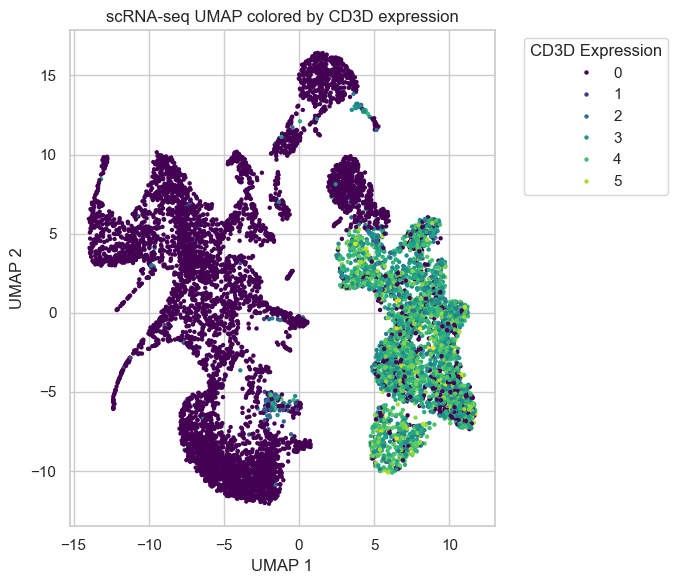

C:\Users\user\AppData\Local\Temp\ipykernel_12968\3532469992.py:27: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


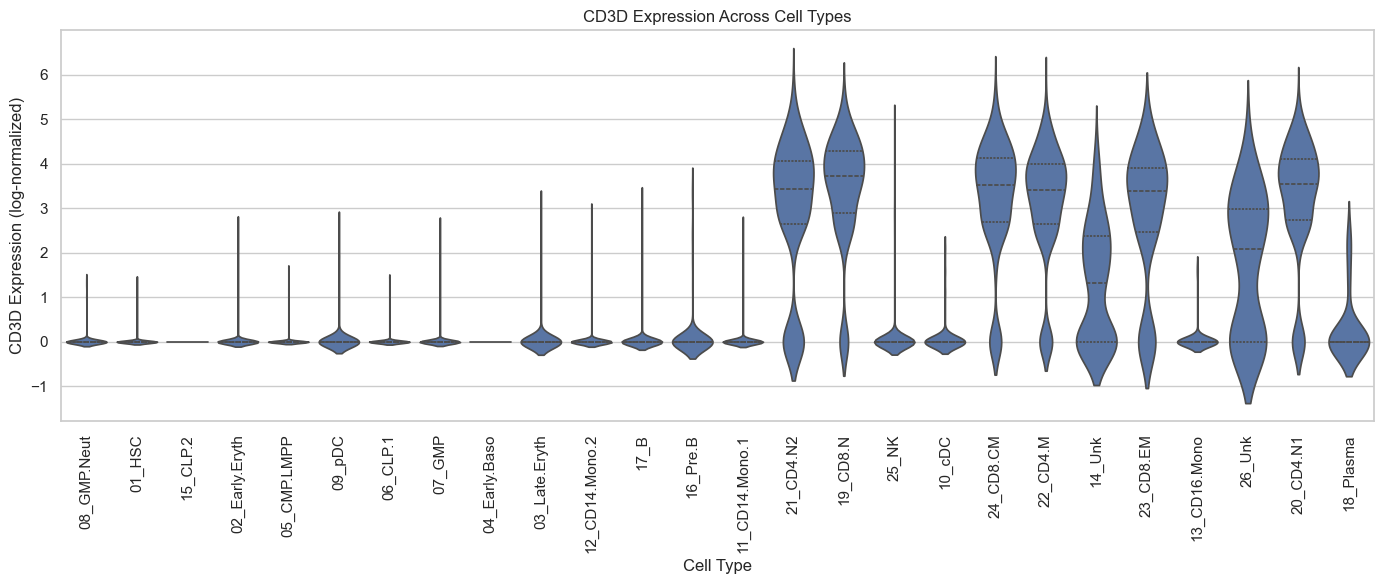

In [ ]:
# CODE HERE
scRNA_depth = scRNA_counts.sum(axis=1)
scRNA_normalized = np.log2((scRNA_counts.div(scRNA_depth, axis=0) * 10000) + 1)
scRNA_cells['CD3D_expression'] = scRNA_normalized['CD3D']


plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=scRNA_cells,
    x='UMAP1', y='UMAP2',
    hue='CD3D_expression',
    palette='viridis',
    s=10, linewidth=0
)
plt.title('scRNA-seq UMAP colored by CD3D expression')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='CD3D Expression', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(
    data=scRNA_cells,
    x='BioClassification',
    y='CD3D_expression',
    scale='width',
    inner='quartile'
)
plt.title('CD3D Expression Across Cell Types')
plt.xlabel('Cell Type')
plt.ylabel('CD3D Expression (log-normalized)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

2. Using the plots from above, which clusters have high expression of the gene?

*ANSWER HERE*<br>**`21_CD4.N2`**,**`22_CD4.M`**,**`20_CD4.N1`**,**`19_CD8.N`**,**`23_CD8.EM`**,**`24_CD8.CM`**


3. Now we know the cell types in which CD3D is expressed. Let's now investigate what role chromatin accessibility plays in the expression of this gene in various cell types. First, use the `peaks2gene` dataframe to identify all of the peaks associated with CD3D.

   **Sanity Check**: You should have 5 peaks

In [69]:
# CODE HERE
cd3d_peaks = peak2genes[peak2genes['gene_name'] == 'CD3D']
num_cd3d_peaks = cd3d_peaks['peakName'].nunique()
cd3d_peak_names  = cd3d_peaks['peakName'].unique().tolist()

print(f"Number of peak:{num_cd3d_peaks}")
print(f"Unique peaks associated with CD3D: {cd3d_peak_names}")

Number of peak:5
Unique peaks associated with CD3D: ['chr11_118051090_118051590', 'chr11_118175165_118175665', 'chr11_118176355_118176855', 'chr11_118209249_118209749', 'chr11_118269437_118269937']


4. Now, let's color the signal of each of the peaks identified in the last question over the scATAC-seq UMAP plot. In addition, print the mean ATAC signal of each peak for each cell type. We suggest using the `groupby` and `describe` methods to get summary statistics for each cell type. It looks like it's easier to visualize these data when looking at summary statistics than in a colored UMAP figure. Why is this the case?

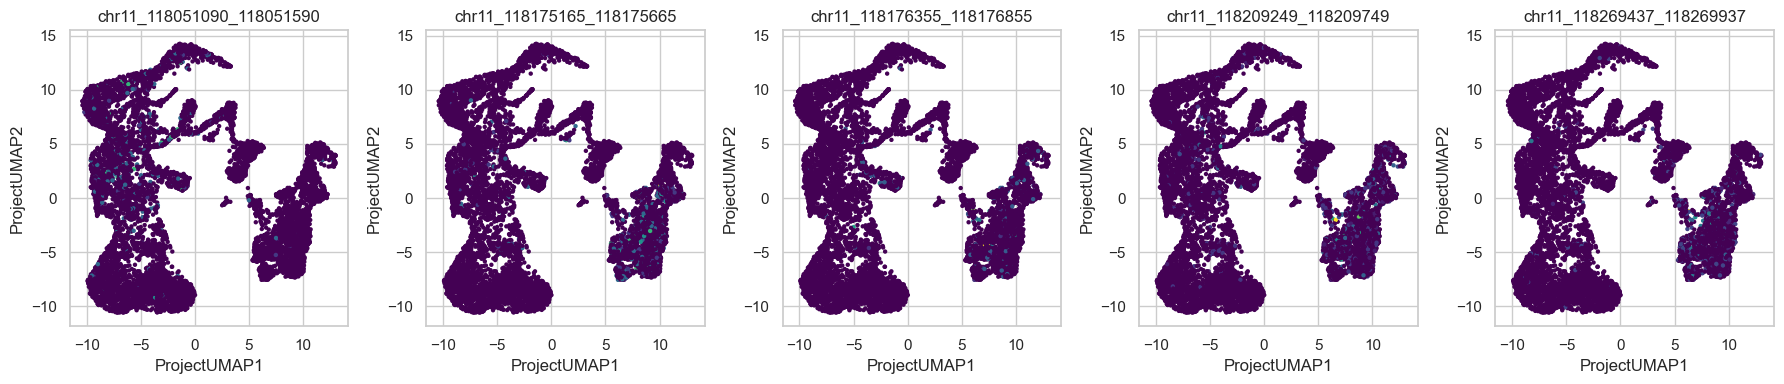

In [ ]:
# CODE HERE
for peak in cd3d_peak_names:
    scATAC_cells[peak] = scATAC_counts[peak]

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, len(cd3d_peak_names), figsize=(18, 4))
for i, peak in enumerate(cd3d_peak_names):
    sns.scatterplot(
        ax=axes[i],
        data=scATAC_cells,
        x='ProjectUMAP1', y='ProjectUMAP2',
        hue=peak,
        palette='viridis',
        s=10, linewidth=0
    )
    axes[i].set_title(peak)
    axes[i].legend([], [], frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
peak_summary = scATAC_cells.groupby('BioClassification')[cd3d_peak_names].describe()
display(peak_summary)

chr11_118051090_118051590                                \
                                      count      mean       std  min  25%   
BioClassification                                                           
01_HSC                                394.0  0.096447  0.484716  0.0  0.0   
02_Early.Eryth                        549.0  0.080146  0.401806  0.0  0.0   
03_Late.Eryth                          40.0  0.000000  0.000000  0.0  0.0   
04_Early.Baso                         161.0  0.024845  0.222214  0.0  0.0   
05_CMP.LMPP                           728.0  0.098901  0.464532  0.0  0.0   
06_CLP.1                              301.0  0.142857  0.591205  0.0  0.0   
07_GMP                                701.0  0.104137  0.443038  0.0  0.0   
08_GMP.Neut                           477.0  0.134172  0.613937  0.0  0.0   
09_pDC                                232.0  0.133621  0.529877  0.0  0.0   
10_cDC                                 89.0  0.033708  0.235943  0.0  0.0   
11_CD14.Mono.1                        649.0  0.030817  0.270413  0.0  0.0   
12_CD14.Mono.2                       1150.0  0.015652  0.176313  0.0  0.0   
13_Unk                                143.0  0.027972  0.203631  0.0  0.0   
14_Unk                                 50.0  0.020000  0.141421  0.0  0.0   
15_CLP.2                              229.0  0.074236  0.457577  0.0  0.0   
16_Pre.B                              311.0  0.035370  0.257850  0.0  0.0   
17_B                                  536.0  0.003731  0.086387  0.0  0.0   
18_Plasma                              28.0  0.000000  0.000000  0.0  0.0   
19_CD8.N                              190.0  0.005263  0.072548  0.0  0.0   
20_CD4.N1                             566.0  0.005300  0.126099  0.0  0.0   
21_CD4.N2                             484.0  0.014463  0.150216  0.0  0.0   
22_CD4.M                              932.0  0.012876  0.166616  0.0  0.0   
23_CD8.EM                             154.0  0.000000  0.000000  0.0  0.0   
24_CD8.CM                             510.0  0.001961  0.044281  0.0  0.0   
25_NK                                 246.0  0.016260  0.179966  0.0  0.0   
26_Unk                                150.0  0.020000  0.182083  0.0  0.0   

                                 chr11_118175165_118175665            ...  \
                   50%  75%  max                     count      mean  ...   
BioClassification                                                     ...   
01_HSC             0.0  0.0  4.0                     394.0  0.012690  ...   
02_Early.Eryth     0.0  0.0  4.0                     549.0  0.016393  ...   
03_Late.Eryth      0.0  0.0  0.0                      40.0  0.000000  ...   
04_Early.Baso      0.0  0.0  2.0                     161.0  0.000000  ...   
05_CMP.LMPP        0.0  0.0  4.0                     728.0  0.013736  ...   
06_CLP.1           0.0  0.0  4.0                     301.0  0.026578  ...   
07_GMP             0.0  0.0  4.0                     701.0  0.027104  ...   
08_GMP.Neut        0.0  0.0  6.0                     477.0  0.039832  ...   
09_pDC             0.0  0.0  4.0                     232.0  0.043103  ...   
10_cDC             0.0  0.0  2.0                      89.0  0.022472  ...   
11_CD14.Mono.1     0.0  0.0  4.0                     649.0  0.004622  ...   
12_CD14.Mono.2     0.0  0.0  3.0                    1150.0  0.001739  ...   
13_Unk             0.0  0.0  2.0                     143.0  0.139860  ...   
14_Unk             0.0  0.0  1.0                      50.0  0.020000  ...   
15_CLP.2           0.0  0.0  4.0                     229.0  0.000000  ...   
16_Pre.B           0.0  0.0  2.0                     311.0  0.054662  ...   
17_B               0.0  0.0  2.0                     536.0  0.001866  ...   
18_Plasma          0.0  0.0  0.0                      28.0  0.000000  ...   
19_CD8.N           0.0  0.0  1.0                     190.0  0.300000  ...   
20_CD4.N1          0.0  0.0  3.0                     566.0  0.174912  ...   
21_CD4.N2    

*ANSWER HERE*<br>While UMAP plots give a spatial overview, they can be visually dense and hard to quantify, especially when signals are subtle or spread out. Summary statistics like mean accessibility per cell type allow for clear comparisons, highlighting which specific cell types have elevated accessibility at regulatory peaks. This is particularly useful when interpreting trends across dozens of cell types.

5. In which cell types are each of these peaks occurring? There should be one peak that is different from the others. Which peak is this?

*ANSWER HERE*<br>**`chr11_118175165_118175665`**,**`chr11_118176355_118176855`**,**`chr11_118209249_118209749`**,**`chr11_118269437_118269937`**. <br>**`chr11_118051090_118051590`** is different from others.


6. What do you think is the role of the segment of DNA at the peak that is different? Why? What do you think is the role of the DNA segment at the other peaks?

*ANSWER HERE*<br>The peak at **`chr11_118051090_118051590`**, which shows a different accessibility pattern compared to the others, is likely a promoter region or a regulatory element active in non–T-cells or early progenitors, as it does not correlate with CD3D expression or the T-cell UMAP clusters. In contrast, the other peaks—such as **`chr11_118175165_118175665`**, **`chr11_118176355_118176855`**, and others—are likely T-cell–specific enhancers, as their accessibility closely matches the expression of CD3D and is localized to T-cell populations in the UMAP, suggesting a role in driving CD3D transcription in a lineage-specific manner.

## 3: Mixed-Phenotype Acute Leukemia (MPAL) Cells

Great! In the last section we were able to learn about how different regulatory elements can have variable associations with gene epxression, and how chromatin accessibility patterns allows the cell to regulate gene expression. Now, we're interested in looking at how gene expression changes in our disease cells, and how that might be impacted by chromatin accessibility. Let's see if we can uncover something from the data!

#### Import the data

Let's load in the scRNA and scATAC-seq data for the diseased cells. Again, in order to make this manageable for a personal computer, I sampled 5000 MPAL cells for both datasets, and I am using the same filtered peaks from the previous scATAC-seq dataset.

In [22]:
scRNA_MPAL_genes = pd.read_csv('./Data/scRNA-MPAL-genes-meta.csv', index_col=0)
scRNA_MPAL_genes = scRNA_MPAL_genes.set_index('gene_name')
scRNA_MPAL_genes.head()

,seqnames,start,end,width,strand,gene_id,exonLength
gene_name,,,,,,,
FAM138A,chr1,34554,36081,1528,-,ENSG00000237613,1219
OR4F5,chr1,69091,70008,918,+,ENSG00000186092,918
AL627309.1,chr1,134901,139379,4479,-,ENSG00000237683,2661
OR4F29,chr1,367640,368634,995,+,ENSG00000235249,995
OR4F16,chr1,621059,622053,995,-,ENSG00000185097,995


In [23]:
scRNA_MPAL_cells = pd.read_csv('./Data/scRNA-MPAL-cells-meta.csv', index_col=0)
scRNA_MPAL_cells.head()

,Group,nUMI_pre,nUMI,nGene,ProjectUMAP1,ProjectUMAP2,ProjectClassification,Barcode
RM2:AAACCTGAGTGTCCCG-1,MPAL5R_T1,1802,1441,896,-6.581877,3.819128,Progenitor_Like,AAACCTGAGTGTCCCG-1
RM2:AAATGCCCAAATTGCC-1,MPAL5R_T1,1945,1036,600,-5.550443,2.505810,Myeloid_Like,AAATGCCCAAATTGCC-1
RM2:AACCGCGTCTTCTGGC-1,MPAL5R_T1,2077,1358,856,-4.863672,1.495551,Myeloid_Like,AACCGCGTCTTCTGGC-1
RM2:AAGACCTAGTAATCCC-1,MPAL5R_T1,1640,1004,632,-6.701039,4.688607,Progenitor_Like,AAGACCTAGTAATCCC-1
RM2:AAGCCGCTCATTGCCC-1,MPAL5R_T1,2038,1086,667,-5.962654,3.973288,Progenitor_Like,AAGCCGCTCATTGCCC-1


In [24]:
scRNA_MPAL_counts = pd.read_csv('./Data/scRNA-MPAL-counts.csv', index_col=0).T
scRNA_MPAL_counts.columns = scRNA_genes.index
scRNA_MPAL_counts.head()

gene_name,FAM138A,OR4F5,AL627309.1,OR4F29,OR4F16,FAM87B,LINC00115,FAM41C,AL645608.2,SAMD11,...,LSS,AP001468.1,MCM3AP-AS1,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
RM2:AAACCTGAGTGTCCCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
RM2:AAATGCCCAAATTGCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RM2:AACCGCGTCTTCTGGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RM2:AAGACCTAGTAATCCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RM2:AAGCCGCTCATTGCCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
scATAC_MPAL_peaks = pd.read_csv('./Data/scATAC-MPAL-peaks-meta.csv', index_col=0)
scATAC_MPAL_peaks['peak_name'] = scATAC_MPAL_peaks['seqnames']+'_'+scATAC_MPAL_peaks['start'].astype('str')+'_'+scATAC_MPAL_peaks['end'].astype('str')
scATAC_MPAL_peaks = scATAC_MPAL_peaks.set_index('peak_name')
scATAC_MPAL_peaks.head()

,seqnames,start,end,width,strand,score,scoreQuantile,name,GC
peak_name,,,,,,,,,
chr1_762677_763177,chr1,762677,763177,501,*,1775.52063,0.961247,scATAC_16,0.688623
chr1_772952_773452,chr1,772952,773452,501,*,230.24321,0.599258,scATAC_18,0.516966
chr1_773634_774134,chr1,773634,774134,501,*,1448.94360,0.854988,scATAC_19,0.457086
chr1_791914_792414,chr1,791914,792414,501,*,214.05739,0.718766,scATAC_23,0.550898
chr1_805049_805549,chr1,805049,805549,501,*,5867.58594,0.978049,scATAC_30,0.738523


In [26]:
scATAC_MPAL_cells = pd.read_csv('./Data/scATAC-MPAL-cells-meta.csv', index_col=0)
scATAC_MPAL_cells.head()

,FRIP,TotalReads,Group,Barcode,initialClusters,UMAP1,UMAP2,Clusters,ProjectUMAP1,ProjectUMAP2,ProjectClassification
MPAL_A_R1_6,0.589342,22330,MPAL1_T1,TTCAACTAGTTGCTTG-1,Cluster32,-10.029607,4.987849,Cluster32,-5.543120,5.890089,Progenitor_Like
MPAL_A_R1_10,0.492322,8336,MPAL1_T1,CTTCCAGAGGGTCTGA-1,Cluster32,-11.593816,3.775510,Cluster32,-5.808113,6.329150,Progenitor_Like
MPAL_A_R1_3,0.633606,50544,MPAL1_T1,AATACGCGTCAGAAAT-1,Cluster16,3.334332,11.544784,Cluster16,6.116799,-4.297342,Healthy_Like
MPAL_A_R1_19,0.550786,19986,MPAL1_T1,TCAAGGTCACAGTTCA-1,Cluster32,-13.578980,4.931208,Cluster32,-5.409777,6.185191,Progenitor_Like
MPAL_A_R1_18,0.619786,13616,MPAL1_T1,ATTTGTCCAAAGCTGG-1,Cluster33,-7.983722,0.265111,Cluster33,-5.094716,-5.586407,Myeloid_Like


In [27]:
scATAC_MPAL_counts = pd.read_csv('./Data/scATAC-MPAL-counts.csv', index_col=0).T
scATAC_MPAL_counts.columns = scATAC_MPAL_peaks.index
scATAC_MPAL_counts.head()

peak_name,chr1_762677_763177,chr1_772952_773452,chr1_773634_774134,chr1_791914_792414,chr1_805049_805549,chr1_834039_834539,chr1_856330_856830,chr1_867079_867579,chr1_893848_894348,chr1_901299_901799,...,chrX_153712829_153713329,chrX_153770594_153771094,chrX_153832177_153832677,chrX_153882623_153883123,chrX_153888183_153888683,chrX_154012368_154012868,chrX_154029742_154030242,chrX_154030288_154030788,chrX_154031719_154032219,chrX_154664524_154665024
BMM_R1_1577,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BMM_R1_167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BMM_R1_1854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BMM_R1_2393,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BMM_R1_2417,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### a) Investigating MPAL Cells

1. Let's start our analysis of MPAL cells by first normalizing our data in the same way as the healthy cells. Normalize the data in the way described below:

    scRNA-seq, follow the paper: "We first log normalized the transcript counts by first depth normalizing to 10,000 and adding a pseudocount before a log2 transform (log2(counts per ten thousand transcripts + 1))"

   For the scATAC-seq dataset, use the same method (log2(counts per ten thousand + 1)) to normalize the data.

**Sanity Check**: The sum of your normalized MPAL scRNA count matrix should be `18933584.388`, and the sum of your normalized MPAL scATAC count matrix should be `17343784.810`.


In [ ]:
# CODE HERE
scRNA_MPAL_depth = scRNA_MPAL_counts.sum(axis=1)
scRNA_MPAL_normalized = scRNA_MPAL_counts.div(scRNA_MPAL_depth, axis=0) * 10000**-
scRNA_MPAL_normalized = np.log2(scRNA_MPAL_normalized + 1)# Log transform 

scATAC_MPAL_depth = scATAC_MPAL_counts.sum(axis=1)
scATAC_MPAL_normalized = scATAC_MPAL_counts.div(scATAC_MPAL_depth, axis=0) * 10000
scATAC_MPAL_normalized = np.log2(scATAC_MPAL_normalized + 1)

In [ ]:
total_sum_scRNA_MPAL = scRNA_MPAL_normalized.values.sum()
print(f"Total sum of normalized scRNA-seq matrix: {total_sum_scRNA_MPAL:.2f}")
total_sum_scATAC_MPAL = scATAC_MPAL_normalized.values.sum()
print(f"Total sum of normalized scATAC-seq matrix: {total_sum_scATAC_MPAL:.2f}")

Total sum of normalized scRNA-seq matrix: 18933584.39
Total sum of normalized scATAC-seq matrix: 17343784.81


2. Let's take a look at the CD69, a gene that was investigated in detail in the paper. First, let's plot CD69 expression in the various types of healthy cells to see what CD69 expression should look like. Use a violinplot to plot this for each cell type.

C:\Users\user\AppData\Local\Temp\ipykernel_12968\690475491.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


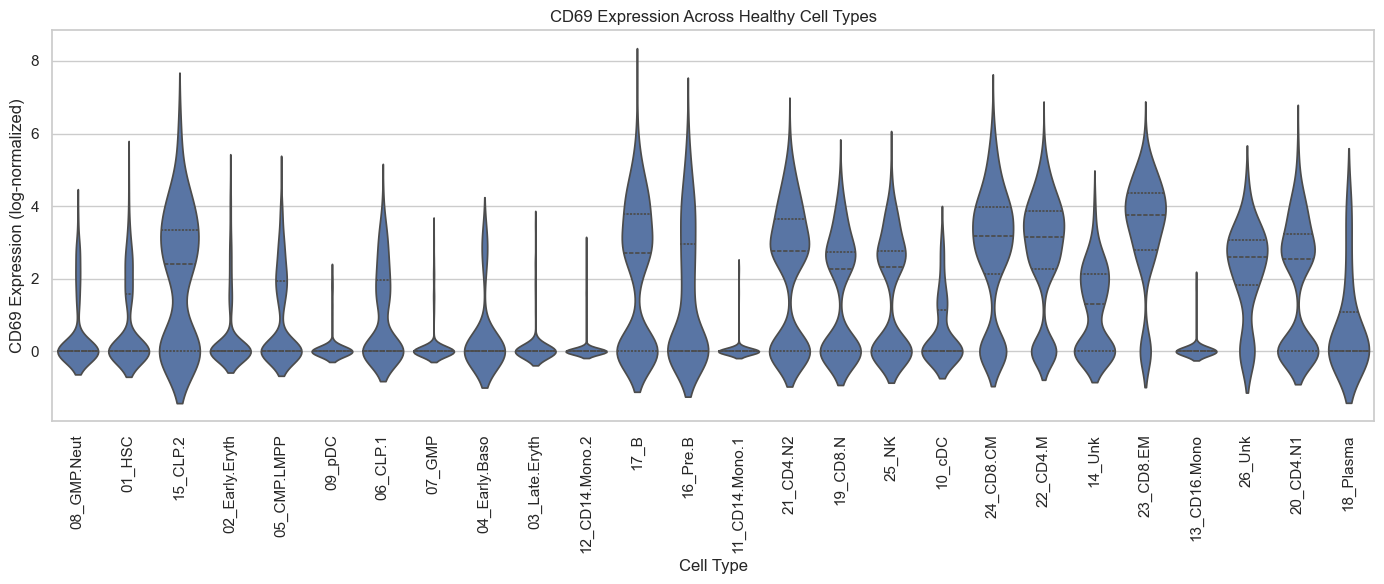

In [ ]:
# CODE HERE
scRNA_cells['CD69_expression'] = scRNA_normalized['CD69']

plt.figure(figsize=(14, 6))
sns.violinplot(
    data=scRNA_cells,
    x='BioClassification',
    y='CD69_expression',
    scale='width',
    inner='quartile'
)
plt.xticks(rotation=90)
plt.title("CD69 Expression Across Healthy Cell Types")
plt.xlabel("Cell Type")
plt.ylabel("CD69 Expression (log-normalized)")
plt.tight_layout()
plt.show()

3. Because the healthy cells have more specific cell types than the MPAL cells, it may be difficult to visualize the relationships in the data. Below, we have consolidated the healthy cell types into fewer categories, located in the `type` column for each dataset. Now, plot CD69 expression using violin plots like above with these new cell types. In which healthy cell types is CD69 expressed?

In [82]:
clusters = {
    'erythroid': ['02','03'],
    'lymphoid': ['06','15','16','17','26'],
    'myeloid': ['08', '09', '07', '12', '11', '10', '14', '13', '18'],
    'progenitor': ['04','01','05'],
    'T/NK': ['25','24','22','23','20','19','21']
}

In [83]:
scRNA_cells['type'] = ''
scATAC_cells['type'] = ''
for type, cluster in clusters.items():
    scRNA_cells.loc[scRNA_cells['BioClassification'].str[0:2].isin(cluster),'type'] = type
    scATAC_cells.loc[scATAC_cells['BioClassification'].str[0:2].isin(cluster),'type'] = type

C:\Users\user\AppData\Local\Temp\ipykernel_12968\870143017.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


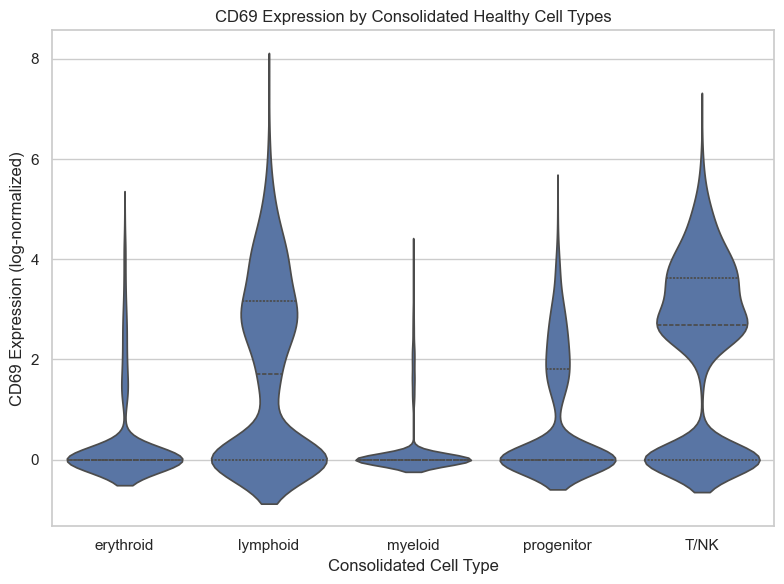

In [84]:
# CODE HERE
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=scRNA_cells,
    x='type',
    y='CD69_expression',
    scale='width',
    inner='quartile',
    order=['erythroid', 'lymphoid', 'myeloid', 'progenitor', 'T/NK']
)
plt.title("CD69 Expression by Consolidated Healthy Cell Types")
plt.xlabel("Consolidated Cell Type")
plt.ylabel("CD69 Expression (log-normalized)")
plt.tight_layout()
plt.show()

*ANSWER HERE*<br>**`lymphoid`** and **`T/NK`**

4. Now, let's see how the various scATAC peaks for CD69 are associated with gene expression for CD69. First, identify which peaks are associated with CD69 expression. Print the names of these peaks.

   **Sanity Check**: You should have 4 peaks

In [ ]:
# CODE HERE
cd69_peaks_scATAC = peak2genes[peak2genes['gene_name'] == 'CD69']
cd69_peak_names_scATAC  = cd69_peaks_scATAC['peakName'].unique().tolist()
cd69_peak_names_scATAC


['chr12_9903873_9904373',
 'chr12_9904380_9904880',
 'chr12_9910146_9910646',
 'chr12_9917278_9917778']

5. Now, investigate each of these peaks using the same consolidated cell types from earlier by printing the mean signal from each cell type for each peak. Again, we suggest using the `groupby` and `describe` functions to print summary statistics for each peak. How are these peaks associated with CD69 expression? What kind of regulatory elements for CD69 could be located at each peak?

In [ ]:
# CODE HERE
scATAC_counts.columns = scATAC_counts.columns.astype(str)
scATAC_normalized.columns = scATAC_normalized.columns.astype(str)

for peak in cd69_peak_names_scATAC:
    scATAC_cells[peak] = scATAC_normalized[peak]

peak_stats_by_type = scATAC_cells.groupby('type')[cd69_peak_names_scATAC].describe()
display(peak_stats_by_type)


chr12_9903873_9904373                                          \
                           count      mean       std  min  25%  50%  75%   
type                                                                       
T/NK                      3082.0  0.091315  0.559309  0.0  0.0  0.0  0.0   
erythroid                  589.0  0.026536  0.302864  0.0  0.0  0.0  0.0   
lymphoid                  1527.0  0.084090  0.531534  0.0  0.0  0.0  0.0   
myeloid                   3519.0  0.048953  0.405153  0.0  0.0  0.0  0.0   
progenitor                1283.0  0.037764  0.326594  0.0  0.0  0.0  0.0   

                     chr12_9904380_9904880            ...  \
                 max                 count      mean  ...   
type                                                  ...   
T/NK        5.313235                3082.0  0.190227  ...   
erythroid   4.590643                 589.0  0.037987  ...   
lymphoid    5.821597                1527.0  0.138669  ...   
myeloid     5.737579                3519.0  0.023759  ...   
progenitor  3.868434                1283.0  0.045666  ...   

           chr12_9910146_9910646           chr12_9917278_9917778            \
                             75%       max                 count      mean   
type                                                                         
T/NK                         0.0  5.853451                3082.0  1.228271   
erythroid                    0.0  4.590643                 589.0  0.518635   
lymphoid                     0.0  5.344942                1527.0  1.037861   
myeloid                      0.0  4.241928                3519.0  0.238686   
progenitor                   0.0  5.141814                1283.0  0.470387   

                                                         
                 std  min  25%  50%       75%       max  
type                                                     
T/NK        1.880527  0.0  0.0  0.0  3.097494  7.750109  
erythroid   1.235585  0.0  0.0  0.0  0.000000  5.178367  
lymphoid    1.744169  0.0  0.0  0.0  2.271900  7.210027  
myeloid     0.853888  0.0  0.0  0.0  0.000000  5.915214  
progenitor  1.232778  0.0  0.0  0.0  0.000000  6.092269  

[5 rows x 32 columns]

*ANSWER HERE*<br>The CD69-associated peaks show accessibility patterns that closely match CD69 expression across cell types, particularly in T/NK and lymphoid cells, where both gene expression and peak accessibility are high suggesting a strong regulatory relationship. Based on their locations and accessibility profiles, these peaks likely represent key regulatory elements: for example, `chr12_9903873_9904373` may act as a promoter, while the others—such as `chr12_9910146_9910646` and `chr12_9917278_9917778`likely function as distal enhancers that drive lineage-specific expression of CD69 in immune cells.

6. Great, we have characterized expression and regulation of CD69 in healthy cells. Now, let's look at MPAL cells. The authors identified cell type classifications for the cancerous cells based on how similar they were to the various healthy cell types. These classifications are stored in the `ProjectClassification` column in our scATAC_cells dataframe. Use this column to plot CD69 expression in the cancer cell-type classifications using a violinplot.

   What is the overall trend of CD69 expression in healthy vs MPAL cells (up/down/the same)? For each of the analogous cell types, what is the trend in MPAL vs healthy cells? How is CD69 expressed differently between the cell types?

C:\Users\user\AppData\Local\Temp\ipykernel_12968\583324639.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


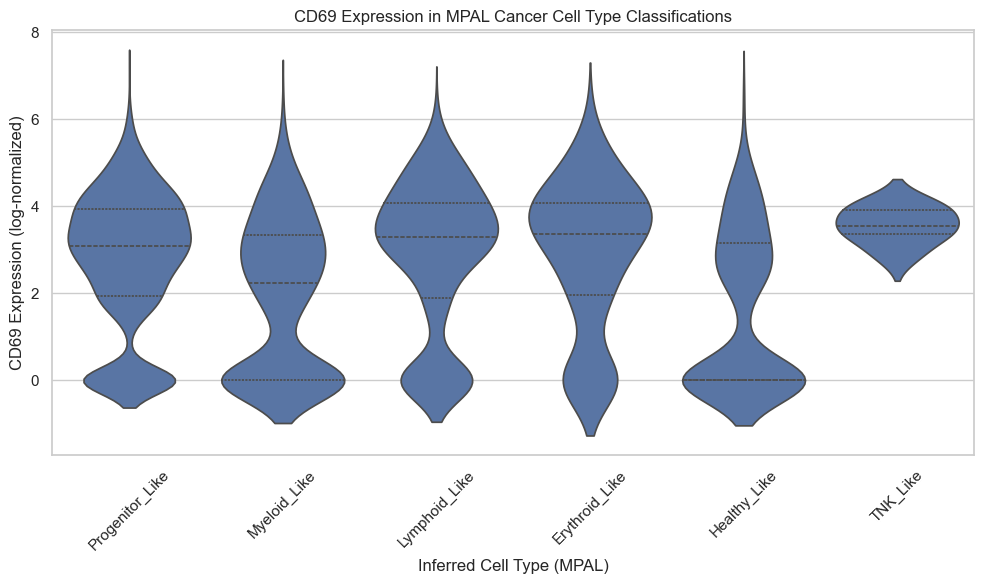

In [ ]:
# CODE HERE
scRNA_MPAL_cells['CD69_expression'] = scRNA_MPAL_normalized['CD69']

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=scRNA_MPAL_cells,
    x='ProjectClassification',
    y='CD69_expression',
    scale='width',
    inner='quartile'
)
plt.title("CD69 Expression in MPAL Cancer Cell Type Classifications")
plt.xlabel("Inferred Cell Type (MPAL)")
plt.ylabel("CD69 Expression (log-normalized)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*ANSWER HERE*<br>CD69 expression is generally higher in MPAL cells compared to healthy cells. In healthy samples, CD69 is mostly found in T/NK and lymphoid cells, but in MPAL, it is also highly expressed in other types like progenitor-like, myeloid-like, and even erythroid-like cells, where it normally isn’t. This suggests that CD69 is misregulated in MPAL cells. Only the T/NK-like MPAL cells show a similar expression pattern to healthy T/NK cells, while the other types show unusual or higher expression, likely due to disrupted gene control in the cancer cells.

7. Let's look at how chromatin accessibility is different in healthy vs MPAL cells. Let's calculate the average signal of each chromatin peak for each MPAL cell type. Like before, print the mean ATAC signal for each cell type, or use the `groupby` and `describe` functions to print the summary statistics for each peak. For each peak, what is the overall trend in how chromatin accessibility is affected by MPAL? For each of the analogous cell types, how is chromatin accessibility different in cancer cells? Finally, how does this validate our conclusions when looking at gene expression, with regards to the regulatory elements at each peak?

In [ ]:
# CODE EHRE
scATAC_MPAL_normalized.columns = scATAC_MPAL_normalized.columns.astype(str)

for peak in cd69_peak_names_scATAC:
    scATAC_MPAL_cells[peak] = scATAC_MPAL_normalized[peak]

mpal_peak_stats_by_type = scATAC_MPAL_cells.groupby('ProjectClassification')[cd69_peak_names_scATAC].describe()
display(mpal_peak_stats_by_type)

chr12_9903873_9904373                                \
                                      count      mean       std  min  25%   
ProjectClassification                                                       
Erythroid_Like                        233.0  0.242231  0.823228  0.0  0.0   
Healthy_Like                          491.0  0.057593  0.434974  0.0  0.0   
Lymphoid_Like                         441.0  0.222594  0.842841  0.0  0.0   
Myeloid_Like                          507.0  0.160696  0.633304  0.0  0.0   
Progenitor_Like                      3308.0  0.220743  0.781843  0.0  0.0   
TNK_Like                               27.0  0.157870  0.820318  0.0  0.0   

                                          chr12_9904380_9904880            \
                       50%  75%       max                 count      mean   
ProjectClassification                                                       
Erythroid_Like         0.0  0.0  4.049997                 233.0  0.353018   
Healthy_Like           0.0  0.0  4.606708                 491.0  0.089813   
Lymphoid_Like          0.0  0.0  6.188687                 441.0  0.282956   
Myeloid_Like           0.0  0.0  3.790456                 507.0  0.325746   
Progenitor_Like        0.0  0.0  5.426829                3308.0  0.369030   
TNK_Like               0.0  0.0  4.262497                  27.0  0.118482   

                       ... chr12_9910146_9910646            \
                       ...                   75%       max   
ProjectClassification  ...                                   
Erythroid_Like         ...                   0.0  3.810664   
Healthy_Like           ...                   0.0  4.576349   
Lymphoid_Like          ...                   0.0  5.499775   
Myeloid_Like           ...                   0.0  5.640961   
Progenitor_Like        ...                   0.0  5.360370   
TNK_Like               ...                   0.0  2.782177   

                      chr12_9917278_9917778                                \
                                      count      mean       std  min  25%   
ProjectClassification                                                       
Erythroid_Like                        233.0  1.040209  1.596941  0.0  0.0   
Healthy_Like                          491.0  0.943721  1.725757  0.0  0.0   
Lymphoid_Like                         441.0  1.112315  1.703943  0.0  0.0   
Myeloid_Like                          507.0  0.638548  1.307172  0.0  0.0   
Progenitor_Like                      3308.0  0.999875  1.518633  0.0  0.0   
TNK_Like                               27.0  1.560734  1.628332  0.0  0.0   

                                                     
                            50%       75%       max  
ProjectClassification                                
Erythroid_Like         0.000000  2.752157  5.383124  
Healthy_Like           0.000000  0.000000  6.458719  
Lymphoid_Like          0.000000  2.691036  6.665372  
Myeloid_Like           0.000000  0.000000  5.321436  
Progenitor_Like        0.000000  2.432237  6.930356  
TNK_Like               1.970903  2.869071  4.513618  

[6 rows x 32 columns]

*ANSWER HERE*<br>Chromatin accessibility at CD69-associated peaks is generally increased in MPAL cells compared to healthy cells, especially in non-immune cell types like myeloid-like and progenitor-like cells, supporting the observation that CD69 is abnormally expressed in MPAL; this suggests that dysregulation of regulatory elements such as enhancers and promoters contributes to the misexpression of CD69 in cancer.

Great! Now we have learned about how CD69 expression and accessibility changes due to cancer. This gene was particularly interesting for the authors as it falls within a list of many genes that they found were proximal to regulatory elements linked to the RUNX1 transcription factor in MPAL cells. This means that increased accessibility of sites that bind to this transcription factor could lead to increased expression of genes like CD69. This could help us understand regulatory mechanisms in MPAL.

## 4: Conclusions and Future Steps

Great! We were able to learn about how gene expression and chromatin accessibility are associated in healthy cells, and we learned more about what changes to gene expression and chromatin accessibility leukemia can be associated with. Now, let's think about conclusions and future steps.

1. In this analysis, we are able to deduce associations in the data, but we do not learn anything about causality (e.g. X causes Y). Why is this? What kind of analysis could allow us to identify causal relationships in the data?

In this analysis, we can see patterns and associations in the data, but we can’t tell what causes what because we didn’t change anything in the system. Time-course studies or controlled studies could allow us to see what happens after a specific change. These types of tests help show cause and effect, not just correlation.

2. From our findings, what kind of questions or data could be interesting for us to learn more about Mixed Phenotype Acute Leukemia?

What drives the abnormal activation of immune genes (like CD69) in non-immune MPAL cells?

## The end!